In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nfl-big-data-bowl-2026-prediction/test_input.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/test.csv
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/nfl_inference_server.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/nfl_gateway.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/__init__.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/templates.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/base_gateway.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/relay.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/kaggle_evaluation.proto
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/__init__.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/generated/kaggle_evaluation_pb2.py
/kaggle/input/nfl-big-data-bowl-2026-prediction/kaggle_evaluation/core/generated/kaggle_evaluati

In [29]:
!pip install pytorch_tabnet

In [30]:
# ============================
# Rutas de datos 
# ============================
DIRECTORIO_DATOS = "/kaggle/input/nfl-big-data-bowl-2026-prediction/train"
DIRECTORIO_TEST = "/kaggle/input/nfl-big-data-bowl-2026-prediction"


def cargar_entradas_y_salidas(directorio: str):
    """
    Carga y concatena los CSV de entrada (pre-release) y salida (post-release)
    para todas las semanas disponibles.

    Returns
    -------
    datos_entrada : DataFrame
        Todos los frames pre-release (10 Hz) de todos los jugadores
        antes del lanzamiento del balón.
    datos_salida : DataFrame
        Frames post-release para los jugadores objetivo
        (solo player_to_predict y durante el vuelo del balón).
    """
    listas_entrada, listas_salida = [], []

    for semana in range(1, 19):   # semanas 1 a 18
        ruta_inp = os.path.join(directorio, f"input_2023_w{semana:02d}.csv")
        ruta_out = os.path.join(directorio, f"output_2023_w{semana:02d}.csv")

        if os.path.exists(ruta_inp):
            listas_entrada.append(pd.read_csv(ruta_inp))

        if os.path.exists(ruta_out):
            listas_salida.append(pd.read_csv(ruta_out))

    if not listas_entrada:
        raise FileNotFoundError("No se encontraron archivos input_2023_wXX.csv en DIRECTORIO_DATOS.")
    if not listas_salida:
        raise FileNotFoundError("No se encontraron archivos output_2023_wXX.csv en DIRECTORIO_DATOS.")

    datos_entrada = pd.concat(listas_entrada, ignore_index=True)
    datos_salida = pd.concat(listas_salida, ignore_index=True)

    return datos_entrada, datos_salida


def cargar_test_pre_release(directorio_test: str):
    """
    Carga el archivo de test pre-release.
    """
    ruta_test_input = os.path.join(directorio_test, "test_input.csv")
    if not os.path.exists(ruta_test_input):
        raise FileNotFoundError("No se encontró test_input.csv en DIRECTORIO_TEST.")
    return pd.read_csv(ruta_test_input)


# ============================
# Carga principal de datos
# ============================
entrada_, salida_ = cargar_entradas_y_salidas(DIRECTORIO_DATOS)
entrada_test_ = cargar_test_pre_release(DIRECTORIO_TEST)

print("=== Estructura general de los DataFrames ===")
print(f"· Entrenamiento pre-release  : filas = {entrada_.shape[0]:,} | columnas = {entrada_.shape[1]}")
print(f"· Entrenamiento post-release : filas = {salida_.shape[0]:,} | columnas = {salida_.shape[1]}")
print(f"· Test pre-release           : filas = {entrada_test_.shape[0]:,} | columnas = {entrada_test_.shape[1]}")
print()

=== Estructura general de los DataFrames ===
· Entrenamiento pre-release  : filas = 4,880,579 | columnas = 23
· Entrenamiento post-release : filas = 562,936 | columnas = 6
· Test pre-release           : filas = 49,753 | columnas = 23



In [31]:
entrada_.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4880579 entries, 0 to 4880578
Data columns (total 23 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   game_id                   int64  
 1   play_id                   int64  
 2   player_to_predict         bool   
 3   nfl_id                    int64  
 4   frame_id                  int64  
 5   play_direction            object 
 6   absolute_yardline_number  int64  
 7   player_name               object 
 8   player_height             object 
 9   player_weight             int64  
 10  player_birth_date         object 
 11  player_position           object 
 12  player_side               object 
 13  player_role               object 
 14  x                         float64
 15  y                         float64
 16  s                         float64
 17  a                         float64
 18  dir                       float64
 19  o                         float64
 20  num_frames_output       

In [32]:
entrada_.head(3)

,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
0,2023090700,101,False,54527,1,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.09,0.39,322.40,238.24,21,63.259998,-0.22
1,2023090700,101,False,54527,2,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.94,0.04,0.61,200.89,236.05,21,63.259998,-0.22
2,2023090700,101,False,54527,3,right,42,Bryan Cook,6-1,210,...,Defensive Coverage,52.33,36.93,0.12,0.73,147.55,240.60,21,63.259998,-0.22


# Preprocesamiento para dataset tabular base

## solo con los jugadores player_to_predict

In [33]:
# Nos quedamos solo con los jugadores objetivo
entrada_players = entrada_.query("player_to_predict == True").copy()

print(f"jugadores objetivo = {entrada_players.shape}")



jugadores objetivo = (1303440, 23)


## Elegir un frame de referencia por jugador

* Tomamos, por defecto, el último frame pre-release para cada.
* (game_id, play_id, nfl_id). Ese será el “snapshot” que ve TabNet.
* Ahora entrada_ref tiene una fila por jugador a predecir.

In [34]:
id_cols = ["game_id", "play_id", "nfl_id"]
col_frame = "frame_id"   # en tu data ya se llama así

entrada_ref = (
    entrada_players
      .sort_values(id_cols + [col_frame])
      .groupby(id_cols, as_index=False)
      .tail(1)          # último frame antes del release
)

print("Frames de referencia:", entrada_ref.shape)
entrada_ref.head()


Frames de referencia: (46045, 23)


,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,...,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
233,2023090700,101,True,44930,26,right,42,Josh Reynolds,6-3,196,...,Targeted Receiver,52.43,14.14,7.90,2.68,99.25,106.80,21,63.259998,-0.22
51,2023090700,101,True,46137,26,right,42,Justin Reid,6-1,204,...,Defensive Coverage,55.82,17.67,5.34,1.80,134.17,184.99,21,63.259998,-0.22
77,2023090700,101,True,52546,26,right,42,L'Jarius Sneed,6-1,193,...,Defensive Coverage,48.01,12.44,2.93,4.75,192.18,309.47,21,63.259998,-0.22
649,2023090700,194,True,41325,32,left,89,Jerick McKinnon,5-9,205,...,Targeted Receiver,88.98,22.23,6.09,2.14,245.74,314.63,9,84.940002,21.75
265,2023090700,194,True,44888,32,left,89,Alex Anzalone,6-3,240,...,Defensive Coverage,85.35,31.23,3.14,3.74,173.44,118.10,9,84.940002,21.75


## bloque multi-frame

In [35]:
# =====================================
# 3. Construir targets multi-frame
#    (x_t0, y_t0, x_t1, y_t1, ..., x_tK, y_tK)
# =====================================

id_cols = ["game_id", "play_id", "nfl_id"]

# Determinar el número máximo de frames futuros según los datos reales
T_MAX = int(entrada_players["num_frames_output"].max())
print("T_MAX detectado (máx num_frames_output):", T_MAX)

# Ordenamos por IDs y frame, y creamos índice temporal t_idx
salida_sorted = salida_.sort_values(id_cols + ["frame_id"])
salida_sorted["t_idx"] = salida_sorted.groupby(id_cols).cumcount()

# Filtrar solo frames válidos [0 .. T_MAX-1]
salida_sorted = salida_sorted[salida_sorted["t_idx"] < T_MAX].copy()

# Pasamos de tabla "larga" a "ancha": columnas = x_tk, y_tk
targets_wide = salida_sorted.pivot_table(
    index=id_cols,
    columns="t_idx",
    values=["x", "y"]
)

# Aplanar MultiIndex de columnas: ('x',0) -> 'x_t0'
targets_wide.columns = [
    f"{var}_t{t}" for (var, t) in targets_wide.columns
]
targets_wide = targets_wide.reset_index()

# Lista de columnas de targets multi-frame
target_cols = [c for c in targets_wide.columns if c.startswith("x_t") or c.startswith("y_t")]

print("targets_wide shape:", targets_wide.shape)
print("Ejemplo de target_cols:", target_cols[:10])

# Rellenar posibles NaNs por fila (frames faltantes)
targets_wide[target_cols] = targets_wide[target_cols].fillna(method="ffill", axis=1)
targets_wide[target_cols] = targets_wide[target_cols].fillna(method="bfill", axis=1)

# =====================================
# 4. Merge final: features pre-release + targets multi-frame
# =====================================

df_train_raw = entrada_ref.merge(
    targets_wide,
    on=id_cols,
    how="inner"
)

print("df_train_raw multi-frame:", df_train_raw.shape)
print(df_train_raw.columns[:25])


T_MAX detectado (máx num_frames_output): 94
targets_wide shape: (46045, 191)
Ejemplo de target_cols: ['x_t0', 'x_t1', 'x_t2', 'x_t3', 'x_t4', 'x_t5', 'x_t6', 'x_t7', 'x_t8', 'x_t9']


/tmp/ipykernel_47/2493133999.py:39: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  targets_wide[target_cols] = targets_wide[target_cols].fillna(method="ffill", axis=1)
/tmp/ipykernel_47/2493133999.py:40: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  targets_wide[target_cols] = targets_wide[target_cols].fillna(method="bfill", axis=1)


df_train_raw multi-frame: (46045, 211)
Index(['game_id', 'play_id', 'player_to_predict', 'nfl_id', 'frame_id',
       'play_direction', 'absolute_yardline_number', 'player_name',
       'player_height', 'player_weight', 'player_birth_date',
       'player_position', 'player_side', 'player_role', 'x', 'y', 's', 'a',
       'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y', 'x_t0',
       'x_t1'],
      dtype='object')


## Definir df_features y df_targets

In [36]:
# ============================
# Definir X (features) e y (targets) para multi-frame
# ============================

# IDs que no entran como features
id_cols = ["game_id", "play_id", "nfl_id"]

# Columnas que NO usaremos como features
cols_no_features = id_cols + target_cols + [
    "player_name",
    "player_birth_date",
    "player_height",
    "player_to_predict",
]

df_features = df_train_raw.drop(columns=cols_no_features, errors="ignore").copy()
df_targets  = df_train_raw[target_cols].copy()

feature_cols = df_features.columns.tolist()

print("Nº features:", len(feature_cols))
print("Nº targets:", len(target_cols))
print("Ejemplo feature_cols:", feature_cols[:10])
print("Ejemplo target_cols:", target_cols[:10])


Nº features: 16
Nº targets: 188
Ejemplo feature_cols: ['frame_id', 'play_direction', 'absolute_yardline_number', 'player_weight', 'player_position', 'player_side', 'player_role', 'x', 'y', 's']
Ejemplo target_cols: ['x_t0', 'x_t1', 'x_t2', 'x_t3', 'x_t4', 'x_t5', 'x_t6', 'x_t7', 'x_t8', 'x_t9']


## Marcar columnas categóricas y numéricas

In [37]:
# ============================
# Categóricas vs Numéricas
# ============================

# categorias que si queremos usar 
cat_cols = [
    "play_direction",
    "player_position",
    "player_side",
    "player_role",
]

# Solo las que realmente están en df_features
cat_cols = [c for c in cat_cols if c in feature_cols]

# El resto → numéricas
num_cols = [c for c in feature_cols if c not in cat_cols]

print("Categóricas:", cat_cols)
print("Numéricas  :", num_cols)


Categóricas: ['play_direction', 'player_position', 'player_side', 'player_role']
Numéricas  : ['frame_id', 'absolute_yardline_number', 'player_weight', 'x', 'y', 's', 'a', 'dir', 'o', 'num_frames_output', 'ball_land_x', 'ball_land_y']


## Imputar NaNs

In [38]:
# ============================
# Imputación de NaNs
# ============================

# Numéricas → mediana
for c in num_cols:
    df_features[c] = df_features[c].astype("float32")
    df_features[c] = df_features[c].fillna(df_features[c].median())

# Categóricas → 'Unknown'
for c in cat_cols:
    df_features[c] = df_features[c].fillna("Unknown")


## Codificar categóricas + cat_idxs y cat_dims

In [39]:
from sklearn.preprocessing import LabelEncoder

# ============================
# LabelEncoding por columna categórica
# ============================

label_encoders = {}   # <-- NUEVO: guardamos los encoders para usarlos luego en test

for c in cat_cols:
    le = LabelEncoder()
    df_features[c] = le.fit_transform(df_features[c].astype(str))
    label_encoders[c] = le   # <-- guardamos el encoder entrenado



# ============================
# cat_idxs y cat_dims según el orden de feature_cols
# ============================

cat_idxs = []
cat_dims = []

for i, c in enumerate(feature_cols):
    if c in cat_cols:
        cat_idxs.append(i)
        cat_dims.append(df_features[c].nunique())

print("cat_idxs:", cat_idxs)
print("cat_dims:", cat_dims)



cat_idxs: [1, 4, 5, 6]
cat_dims: [2, 17, 2, 2]


## X, y y split (ahora con y multi-frame)

In [40]:
from sklearn.model_selection import train_test_split
import numpy as np

# ============================
# Matrices finales
# ============================

X = df_features[feature_cols].values.astype("float32")   # (N, 16)
y = df_targets[target_cols].values.astype("float32")     # (N, 50)

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_valid:", X_valid.shape, "y_valid:", y_valid.shape)


X_train: (36836, 16) y_train: (36836, 188)
X_valid: (9209, 16) y_valid: (9209, 188)


In [41]:
df_targets[target_cols]

,x_t0,x_t1,x_t2,x_t3,x_t4,x_t5,x_t6,x_t7,x_t8,x_t9,...,y_t84,y_t85,y_t86,y_t87,y_t88,y_t89,y_t90,y_t91,y_t92,y_t93
0,53.20,53.96,54.70,55.41,56.09,56.73,57.35,57.92,58.45,58.95,...,2.83,2.83,2.83,2.83,2.83,2.83,2.83,2.83,2.83,2.83
1,56.22,56.63,57.06,57.48,57.91,58.34,58.75,59.14,59.51,59.86,...,4.63,4.63,4.63,4.63,4.63,4.63,4.63,4.63,4.63,4.63
2,47.94,47.86,47.78,47.72,47.71,47.73,47.79,47.91,48.05,48.21,...,5.38,5.38,5.38,5.38,5.38,5.38,5.38,5.38,5.38,5.38
3,88.43,87.88,87.33,86.78,86.23,85.69,85.15,84.61,84.06,84.06,...,20.70,20.70,20.70,20.70,20.70,20.70,20.70,20.70,20.70,20.70
4,85.38,85.40,85.40,85.38,85.32,85.23,85.10,84.92,84.68,84.68,...,26.97,26.97,26.97,26.97,26.97,26.97,26.97,26.97,26.97,26.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46040,42.32,41.95,41.56,41.16,40.73,40.27,39.77,39.24,38.67,38.07,...,46.99,46.99,46.99,46.99,46.99,46.99,46.99,46.99,46.99,46.99
46041,38.43,37.77,37.13,36.51,35.93,35.39,34.89,34.42,34.00,33.62,...,8.15,8.15,8.15,8.15,8.15,8.15,8.15,8.15,8.15,8.15
46042,30.41,30.15,29.94,29.77,29.65,29.56,29.51,29.50,29.53,29.58,...,5.80,5.80,5.80,5.80,5.80,5.80,5.80,5.80,5.80,5.80
46043,37.69,36.94,36.23,35.55,34.90,34.30,33.74,33.22,32.73,32.29,...,7.30,7.30,7.30,7.30,7.30,7.30,7.30,7.30,7.30,7.30


In [42]:
df_features[feature_cols]

,frame_id,play_direction,absolute_yardline_number,player_weight,player_position,player_side,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
0,26.0,1,42.0,196.0,16,1,1,52.430000,14.14,7.90,2.68,99.250000,106.800003,21.0,63.259998,-0.22
1,26.0,1,42.0,204.0,13,0,0,55.820000,17.67,5.34,1.80,134.169998,184.990005,21.0,63.259998,-0.22
2,26.0,1,42.0,193.0,0,0,0,48.009998,12.44,2.93,4.75,192.179993,309.470001,21.0,63.259998,-0.22
3,32.0,0,89.0,205.0,11,1,1,88.980003,22.23,6.09,2.14,245.740005,314.630005,9.0,84.940002,21.75
4,32.0,0,89.0,240.0,9,0,0,85.349998,31.23,3.14,3.74,173.440002,118.099998,9.0,84.940002,21.75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46040,28.0,0,50.0,205.0,0,0,0,42.700001,43.25,3.91,1.69,292.059998,184.339996,17.0,29.340000,47.66
46041,27.0,0,50.0,192.0,0,0,0,39.119999,17.74,6.96,1.16,259.829987,277.179993,18.0,32.139999,6.71
46042,27.0,0,50.0,208.0,4,0,0,30.690001,15.24,3.60,2.04,235.639999,73.570000,18.0,32.139999,6.71
46043,27.0,0,50.0,227.0,16,1,1,38.450001,17.24,7.89,2.06,261.040009,285.480011,18.0,32.139999,6.71


In [43]:
X_train

array([[17.  ,  0.  , 98.  , ...,  9.  , 93.64, 45.53],
       [19.  ,  0.  , 78.  , ..., 11.  , 73.42, 11.25],
       [49.  ,  0.  , 93.  , ..., 13.  , 78.11,  6.02],
       ...,
       [59.  ,  0.  , 72.  , ...,  6.  , 63.78, 15.44],
       [31.  ,  0.  , 49.  , ..., 14.  , 40.86,  3.17],
       [18.  ,  0.  , 11.  , ..., 10.  ,  4.62, 31.25]], dtype=float32)

In [44]:
print("Mínimo:", entrada_players["num_frames_output"].min())
print("Promedio:", entrada_players["num_frames_output"].mean())
print("Máximo:", entrada_players["num_frames_output"].max())


Mínimo: 5
Promedio: 12.685200699686982
Máximo: 94


# Definir y entrenar TabNet (multi-output)

In [45]:
#!pip install pytorch-tabnet -q

from pytorch_tabnet.tab_model import TabNetRegressor
import torch

reg = TabNetRegressor(
    n_d=16,
    n_a=16,
    n_steps=4,
    gamma=1.5,
    n_independent=2,
    n_shared=2,
    lambda_sparse=1e-4,

    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=1e-3),

    mask_type="sparsemax",
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=2
)

reg.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=["train", "valid"],
    eval_metric=["rmse"],
    max_epochs=200,
    patience=30,
    batch_size=1024,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False
)


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 2566.48 | train_rmse: 48.44337844848633| valid_rmse: 48.28007888793945|  0:00:03s
epoch 1  | loss: 2498.69644| train_rmse: 47.93305969238281| valid_rmse: 47.76604080200195|  0:00:07s
epoch 2  | loss: 2414.25144| train_rmse: 47.226600646972656| valid_rmse: 47.065101623535156|  0:00:11s
epoch 3  | loss: 2296.05051| train_rmse: 45.895721435546875| valid_rmse: 45.702239990234375|  0:00:15s
epoch 4  | loss: 2150.65832| train_rmse: 44.27143859863281| valid_rmse: 44.088401794433594|  0:00:19s
epoch 5  | loss: 1980.10607| train_rmse: 42.271751403808594| valid_rmse: 42.06159973144531|  0:00:23s
epoch 6  | loss: 1776.78306| train_rmse: 39.783180236816406| valid_rmse: 39.575069427490234|  0:00:27s
epoch 7  | loss: 1554.55161| train_rmse: 37.095890045166016| valid_rmse: 36.9249382019043|  0:00:31s
epoch 8  | loss: 1331.92418| train_rmse: 34.10200881958008| valid_rmse: 33.93960189819336|  0:00:35s
epoch 9  | loss: 1115.18596| train_rmse: 31.10141944885254| valid_rmse: 30.9250202178

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [46]:
# ============================
# SUBMISSION: predicción sobre test_input + test.csv
# ============================

# Cargamos test.csv (mock con la estructura real del test futuro)
ruta_test_csv = os.path.join(DIRECTORIO_TEST, "test.csv")
test_df = pd.read_csv(ruta_test_csv)

id_cols = ["game_id", "play_id", "nfl_id"]

# 1) Snapshot pre-release para test (igual que en train)
entrada_test_players = entrada_test_.query("player_to_predict == True").copy()

entrada_test_ref = (
    entrada_test_players
      .sort_values(id_cols + ["frame_id"])
      .groupby(id_cols, as_index=False)
      .tail(1)   # último frame pre-release
)

print("entrada_test_ref:", entrada_test_ref.shape)

# 2) Construir df_test_features con MISMAS columnas que en el train
df_test_features = entrada_test_ref[feature_cols].copy()

# === Imputación en test: usamos medianas del train y 'Unknown' ===
for c in num_cols:
    df_test_features[c] = df_test_features[c].astype("float32")
    df_test_features[c] = df_test_features[c].fillna(df_features[c].median())

for c in cat_cols:
    df_test_features[c] = df_test_features[c].fillna("Unknown")
    # aplicar el mismo encoder del train
    le = label_encoders[c]
    # cuidado: categorías nuevas -> las mandamos a una categoría "desconocida"
    df_test_features[c] = df_test_features[c].map(
        lambda v: v if v in le.classes_ else le.classes_[0]
    )
    df_test_features[c] = le.transform(df_test_features[c].astype(str))

# 3) Matriz X_test
X_test = df_test_features[feature_cols].values.astype("float32")

# 4) Predicción multi-frame
y_test_pred = reg.predict(X_test)  # shape = (N_jugadores_test, n_targets)

# 5) Convertimos a DataFrame con mismos nombres de columnas que target_cols
pred_multi = pd.DataFrame(y_test_pred, columns=target_cols)
for c in id_cols:
    pred_multi[c] = entrada_test_ref[c].values

# 6) Expandir a formato largo: una fila por frame_id
n_targets = len(target_cols)
n_frames = n_targets // 2  # pares (x_tk, y_tk)

rows = []
for _, row in pred_multi.iterrows():
    gid, pid, nid = int(row["game_id"]), int(row["play_id"]), int(row["nfl_id"])
    for t in range(n_frames):
        frame_id = t + 1  # t_idx 0 -> frame_id 1
        x_val = row[f"x_t{t}"]
        y_val = row[f"y_t{t}"]
        rows.append({
            "game_id": gid,
            "play_id": pid,
            "nfl_id":  nid,
            "frame_id": frame_id,
            "x": x_val,
            "y": y_val
        })

pred_long = pd.DataFrame(rows)

print("pred_long (toda la trayectoria):", pred_long.shape)

# 7) Nos quedamos solo con los frames que Kaggle realmente evalúa (test.csv)
submission = test_df.merge(
    pred_long,
    on=["game_id", "play_id", "nfl_id", "frame_id"],
    how="left"
)

# 8) Guardar archivo final de envío
submission = submission[["game_id", "play_id", "nfl_id", "frame_id", "x", "y"]]
submission.to_csv("submission.csv", index=False)

print("submission listo:", submission.shape)
submission.head()


entrada_test_ref: (472, 23)
pred_long (toda la trayectoria): (44368, 6)
submission listo: (5837, 6)


,game_id,play_id,nfl_id,frame_id,x,y
0,2024120805,74,54586,1,91.601402,37.668789
1,2024120805,74,54586,2,90.457222,37.431351
2,2024120805,74,54586,3,91.314209,37.538364
3,2024120805,74,54586,4,91.132607,37.246422
4,2024120805,74,54586,5,91.432884,36.353481


## Métricas multi-frame

In [47]:
from sklearn.metrics import mean_squared_error

y_pred_valid = reg.predict(X_valid)   # (N, 50)

# RMSE global (todas las coordenadas de todos los frames)
mse_global = mean_squared_error(
    y_valid.reshape(-1),
    y_pred_valid.reshape(-1)
)
rmse_global = np.sqrt(mse_global)

print("RMSE Global multi-frame:", rmse_global)


RMSE Global multi-frame: 2.1461148


In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# ============================
# MÉTRICAS GLOBALES (todos los frames y coordenadas)
# ============================

# Aplanamos todo: (N, n_targets) -> (N * n_targets,)
y_true_flat = y_valid.reshape(-1)
y_pred_flat = y_pred_valid.reshape(-1)

# MSE
mse_global = mean_squared_error(y_true_flat, y_pred_flat)

# RMSE
rmse_global = np.sqrt(mse_global)

# MAE
mae_global = mean_absolute_error(y_true_flat, y_pred_flat)

# MAPE (evitando división por cero)
epsilon = 1e-7
mape_global = np.mean(
    np.abs((y_valid - y_pred_valid) / (y_valid + epsilon))
) * 100

# R²
r2_global = r2_score(y_true_flat, y_pred_flat)

print("====== MÉTRICAS GLOBALES ======")
print(f"MSE Global : {mse_global:.4f}")
print(f"RMSE Global: {rmse_global:.4f}")
print(f"MAE Global : {mae_global:.4f}")
print(f"MAPE Global: {mape_global:.4f}%")
print(f"R² Global  : {r2_global:.4f}")


# ============================
# (OPCIONAL) RMSE por frame
# ============================

n_targets = y_valid.shape[1]
assert n_targets % 2 == 0, "Se espera pares (x_t, y_t) por frame"

n_frames = n_targets // 2

rmse_por_frame = []

for t in range(n_frames):
    # índices de x_t, y_t en el vector de targets
    idx_x = 2 * t
    idx_y = 2 * t + 1
    
    y_true_xy = y_valid[:, [idx_x, idx_y]]
    y_pred_xy = y_pred_valid[:, [idx_x, idx_y]]
    
    mse_t = mean_squared_error(
        y_true_xy.reshape(-1),
        y_pred_xy.reshape(-1)
    )
    rmse_t = np.sqrt(mse_t)
    rmse_por_frame.append(rmse_t)

print("\n====== RMSE POR FRAME (x_t, y_t juntos) ======")
for t, rmse_t in enumerate(rmse_por_frame):
    print(f"Frame t={t}: RMSE = {rmse_t:.4f}")


====== MÉTRICAS GLOBALES ======
MSE Global : 4.6058
RMSE Global: 2.1461
MAE Global : 1.4846
MAPE Global: 7.2673%
R² Global  : 0.9935

====== RMSE POR FRAME (x_t, y_t juntos) ======
Frame t=0: RMSE = 3.2840
Frame t=1: RMSE = 3.1040
Frame t=2: RMSE = 2.6949
Frame t=3: RMSE = 2.5711
Frame t=4: RMSE = 2.2933
Frame t=5: RMSE = 2.2310
Frame t=6: RMSE = 2.1223
Frame t=7: RMSE = 1.9847
Frame t=8: RMSE = 1.9554
Frame t=9: RMSE = 1.8873
Frame t=10: RMSE = 1.9112
Frame t=11: RMSE = 1.9379
Frame t=12: RMSE = 1.9751
Frame t=13: RMSE = 1.9984
Frame t=14: RMSE = 2.0321
Frame t=15: RMSE = 2.0686
Frame t=16: RMSE = 2.0668
Frame t=17: RMSE = 2.0345
Frame t=18: RMSE = 2.0864
Frame t=19: RMSE = 2.0366
Frame t=20: RMSE = 2.0297
Frame t=21: RMSE = 2.0346
Frame t=22: RMSE = 2.0777
Frame t=23: RMSE = 2.0676
Frame t=24: RMSE = 2.0480
Frame t=25: RMSE = 2.0419
Frame t=26: RMSE = 2.0922
Frame t=27: RMSE = 2.0368
Frame t=28: RMSE = 2.0581
Frame t=29: RMSE = 2.0664
Frame t=30: RMSE = 2.0312
Frame t=31: RMSE = 2.07

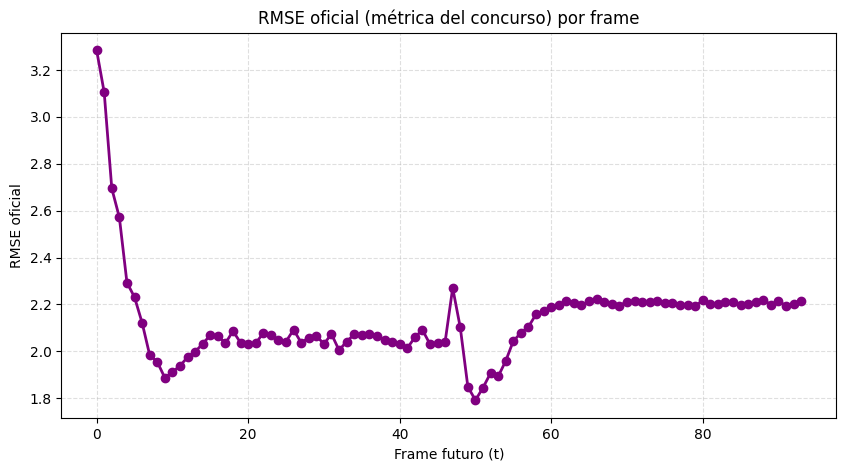

In [49]:
import numpy as np
import matplotlib.pyplot as plt

# ============================
# Cálculo del RMSE oficial por frame
# ============================

rmse_oficial = []

n_targets = y_valid.shape[1]
n_frames = n_targets // 2

for t in range(n_frames):
    idx_x = 2 * t
    idx_y = 2 * t + 1

    x_true = y_valid[:, idx_x]
    y_true = y_valid[:, idx_y]
    x_pred = y_pred_valid[:, idx_x]
    y_pred = y_pred_valid[:, idx_y]

    # Fórmula oficial
    mse_t = ((x_true - x_pred)**2 + (y_true - y_pred)**2).mean() / 2
    rmse_t = np.sqrt(mse_t)

    rmse_oficial.append(rmse_t)

# ============================
# Gráfico
# ============================

plt.figure(figsize=(10,5))
plt.plot(range(n_frames), rmse_oficial, marker='o', color='purple', linewidth=2)
plt.xlabel("Frame futuro (t)")
plt.ylabel("RMSE oficial")
plt.title("RMSE oficial (métrica del concurso) por frame")
plt.grid(True, linestyle="--", alpha=0.4)
plt.show()
